In [159]:
# import libraries
#import boto3, re, sys, math, json, os, sagemaker, 
import urllib.request
import numpy as np                                
import pandas as pd  
import matplotlib
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime       
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
#from sagemaker.predictor import csv_serializer  
#from sagemaker import get_execution_role

# Global variables
Data_Download_Completed = True
Use_Small_DataSet = False
Small_Data_Already_Split = True
PCA_Component_Number = 5
Feature_Weight_Step_Threshold = 0.00001


In [160]:
# Grab the necessary dataset files from the origin sources
data_dir="/home/will/Desktop/CSC8515/"
unsw_nb15_mainurl = 'https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/'
unsw_nb15_training_file = 'UNSW_NB15_training-set.csv'
unsw_nb15_feature_file = 'NUSW-NB15_features.csv' # misspelling in the origin data file name
unsw_nb15_test_file = 'UNSW_NB15_testing-set.csv'
download_training_url = unsw_nb15_mainurl + unsw_nb15_training_file
download_feature_url = unsw_nb15_mainurl + unsw_nb15_feature_file
download_test_url = unsw_nb15_mainurl + unsw_nb15_test_file

if(Data_Download_Completed !=True):
    try:
      urllib.request.urlretrieve (download_feature_url, unsw_nb15_feature_file)
      print('Success: ' + unsw_nb15_feature_file)
    except Exception as e:
      print('Data load error: ',e)

    try:
      urllib.request.urlretrieve (download_training_url, unsw_nb15_training_file)
      print('Success: ' + unsw_nb15_training_file)
    except Exception as e:
      print('Data load error: ',e)


In [161]:
# Load data
# Must declare data_dir as the directory of training and test files
raw_data_filename = data_dir + unsw_nb15_training_file
if(Use_Small_DataSet !=True):
    print('Loading raw data')
    try:
        raw_data = pd.read_csv(raw_data_filename, index_col=0, header=0)
        print('Success: Data loaded into dataframe.')
    except Exception as e:
        print('Data load error: ',e)
    selected_data = raw_data
    print(selected_data.shape)


Loading raw data
Success: Data loaded into dataframe.
(82332, 44)


In [162]:

# Split smaller dataset for experimentation
samll_filename = data_dir + 'UNSW_NB15_training-small.csv'
if((Use_Small_DataSet ==True) and (Small_Data_Already_Split !=True)):
    remaining_data, selected_data = np.split(raw_data.sample(frac=1, random_state=1729), [int(0.80 * len(raw_data))])
    print(remaining_data.shape, selected_data.shape)
    selected_data.head(10)
    # Write the samll data set to disk
    selected_data.to_csv(samll_filename)

In [163]:
# Read back the small data
if(Use_Small_DataSet ==True):
    try:
        small_data = pd.read_csv(samll_filename, index_col=0, header=0)
        print('Success: Data loaded into dataframe.')
    except Exception as e:
        print('Data load error: ',e)
    selected_data = small_data
    print(selected_data.shape)


In [164]:
    selected_data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


In [165]:
# Now gather the list of feature names
print('Loading feature list')
try:
    feature_data = pd.read_csv(raw_data_filename, index_col=0, header=None, nrows=1)
    print('Success: Feature list loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)
#print(feature_data)
feature_list = feature_data.values[0]
feature_only_list = np.delete(feature_list, [(feature_list.shape[0]-2), (feature_list.shape[0]-1)])
print(feature_only_list.shape)
feature_only_list

Loading feature list
Success: Feature list loaded into dataframe.
(42,)


array(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss',
       'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb',
       'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean',
       'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl',
       'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'], dtype=object)

In [166]:
# Create a new function
def num_missing(x):
    return sum(x.isnull())

#Apply per column
print("Missing values per column:")
print(selected_data.apply(num_missing, axis=0))


Missing values per column:
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_

In [168]:
pd.crosstab(selected_data['attack_cat'], selected_data['service'], margins=True)

service,-,dhcp,dns,ftp,ftp-data,http,irc,pop3,radius,smtp,snmp,ssh,ssl,All
attack_cat,,,,,,,,,,,,,,
Analysis,677,0,0,0,0,0,0,0,0,0,0,0,0,677
Backdoor,572,0,0,2,0,9,0,0,0,0,0,0,0,583
DoS,3372,9,40,23,6,493,3,26,0,107,6,0,4,4089
Exploits,5839,12,68,500,441,2804,2,396,2,1049,2,4,13,11132
Fuzzers,5527,0,17,267,0,251,0,0,0,0,0,0,0,6062
Generic,411,5,18162,2,0,213,0,1,5,58,1,0,13,18871
Normal,27375,0,3068,758,949,4013,0,0,2,635,0,200,0,37000
Reconnaissance,2992,0,12,0,0,470,0,0,0,2,20,0,0,3496
Shellcode,378,0,0,0,0,0,0,0,0,0,0,0,0,378


In [169]:
print('Transforming data')
# Factorize columns: "proto", "service", "state", "attack_cat"
selected_data['proto'], protocols = pd.factorize(selected_data['proto'])
selected_data['service'], services = pd.factorize(selected_data['service'])
selected_data['state'], states    = pd.factorize(selected_data['state'])
#selected_data['attack_cat'], attacks = pd.factorize(selected_data['attack_cat'])
selected_data.head()

Transforming data


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.000011,0,0,0,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000008,0,0,0,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
3,0.000005,0,0,0,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
4,0.000006,0,0,0,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
5,0.000010,0,0,0,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


In [170]:
pd.crosstab(selected_data['attack_cat'], selected_data['service'], margins=True)

service,0,1,2,3,4,5,6,7,8,9,10,11,12,All
attack_cat,,,,,,,,,,,,,,
Analysis,677,0,0,0,0,0,0,0,0,0,0,0,0,677
Backdoor,572,9,2,0,0,0,0,0,0,0,0,0,0,583
DoS,3372,493,23,6,107,26,40,6,4,9,3,0,0,4089
Exploits,5839,2804,500,441,1049,396,68,2,13,12,2,2,4,11132
Fuzzers,5527,251,267,0,0,0,17,0,0,0,0,0,0,6062
Generic,411,213,2,0,58,1,18162,1,13,5,0,5,0,18871
Normal,27375,4013,758,949,635,0,3068,0,0,0,0,2,200,37000
Reconnaissance,2992,470,0,0,2,0,12,20,0,0,0,0,0,3496
Shellcode,378,0,0,0,0,0,0,0,0,0,0,0,0,378


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f25c629aac8>,
      dtype=object)

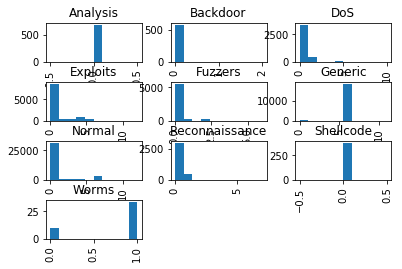

In [171]:
selected_data.hist(column='service', by='attack_cat')

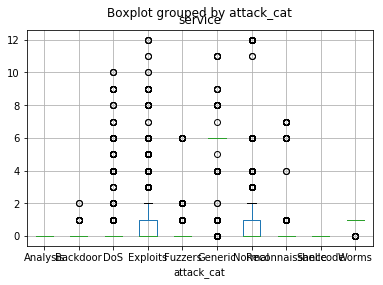

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline
selected_data.boxplot(column='service', by='attack_cat')

In [173]:
selected_data.describe()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,1.006756,8.811216,1.901739,0.862046,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,4.710444,25.348181,2.642982,1.087298,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000008,0.000000,0.000000,0.000000,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,0.014138,2.000000,0.000000,1.000000,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,0.719360,2.000000,6.000000,1.000000,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,59.999989,130.000000,12.000000,6.000000,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


In [174]:
# separate features (columns 1..42) and labels (column 43, 44)
features= selected_data.iloc[:,:selected_data.shape[1]-2]
#labels= selected_data.iloc[:,selected_data.shape[1]-1:]
attack_labels=selected_data['attack_cat']
print('features shape is:', features.shape, 'labels shape is:', attack_labels.shape)
attack_labels.head(10)


features shape is: (82332, 42) labels shape is: (82332,)


id
1     Normal
2     Normal
3     Normal
4     Normal
5     Normal
6     Normal
7     Normal
8     Normal
9     Normal
10    Normal
Name: attack_cat, dtype: object

In [175]:
anormaly_labels=selected_data['label']
anormaly_labels.head(10)

id
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
Name: label, dtype: int64

In [176]:
# Study the training data
labels= attack_labels.values # this becomes a 'horizontal' array
#print(labels)
UNSW_NB15_Label_names2 = np.unique(labels, return_counts=True)
#print(UNSW_NB15_Label_names2)
UNSW_NB15_Label_names = {}
for i in range(len(UNSW_NB15_Label_names2[0])):
    UNSW_NB15_Label_names[UNSW_NB15_Label_names2[0][i]] = UNSW_NB15_Label_names2[1][i]
# ordered_UNSW_NB15_Label_names = sorted(UNSW_NB15_Label_names.items(), key=lambda x: x[1], reverse=True)
ordered_UNSW_NB15_Label_names = sorted(UNSW_NB15_Label_names, key=UNSW_NB15_Label_names.__getitem__, reverse=True)
#UNSW_NB15_Label_names = np.sort(UNSW_NB15_Label_names, axis=0, order=Count)
print('Attack Category', '\t\t\t Counts')
short_cat_name = np.copy(ordered_UNSW_NB15_Label_names)
for i, cat in enumerate(short_cat_name):
    if(cat == 'Reconnaissance'):
        short_cat_name[i] = 'Reconn'
for i, cat in enumerate(short_cat_name):
    if(len(cat) < 6):
        print('\t', cat, '\t\t\t\t', UNSW_NB15_Label_names[ordered_UNSW_NB15_Label_names[i]])
    else:
        print('\t', cat, '\t\t\t', UNSW_NB15_Label_names[ordered_UNSW_NB15_Label_names[i]])
print('Total # of Data Points: \t\t', attack_labels.shape[0])

    

Attack Category 			 Counts
	 Normal 			 37000
	 Generic 			 18871
	 Exploits 			 11132
	 Fuzzers 			 6062
	 DoS 				 4089
	 Reconn 			 3496
	 Analysis 			 677
	 Backdoor 			 583
	 Shellcode 			 378
	 Worms 				 44
Total # of Data Points: 		 82332


In [177]:
# Separate data in train set and test set
df= pd.DataFrame(features)
# create training and testing vars
# Note: train_size + test_size < 1.0 means we are subsampling
# Use small numbers for slow classifiers, as KNN, Radius, SVC,...
X_train, X_test, y_train, y_test = train_test_split(df, labels, train_size=0.8, test_size=0.2, random_state=1)
print('X_train, y_train:', X_train.shape, y_train.shape)
print('X_test, y_test:', X_test.shape, y_test.shape)

X_train, y_train: (65865, 42) (65865,)
X_test, y_test: (16467, 42) (16467,)


In [178]:
#remove redundant features
#train_data['num_outbound_cmds'].value_counts()
#train_data.drop('num_outbound_cmds', axis=1, inplace=True)
#train_data['is_host_login'].value_counts()
#train_data.drop('is_host_login', axis=1, inplace=True)
#train_data.head(10)

In [179]:
# Training, choose model by commenting/uncommenting clf=
print('Training model...')
clf= RandomForestClassifier(n_jobs=-1, random_state=3, n_estimators=102)
#, max_features=0.8, min_samples_leaf=3, n_estimators=500, min_samples_split=3, random_state=10, verbose=1)
# clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, presort=False)
# clf= svm.SVC(kernel='rbf')
#clf= neighbors.KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', metric='manhattan')

trained_model= clf.fit(X_train, y_train)


Training model...


In [181]:
# Predicting
print('Predicting...')
y_pred = clf.predict(X_test)
#print('Predited labels: \t', y_pred)
#print('True labels: \t\t', y_test)

results = confusion_matrix(y_test, y_pred, ordered_UNSW_NB15_Label_names)
print('\nConfusion matrix:\n', results)

print('Computing performance metrics')
print('\nAccuracy result:', accuracy_score(y_test, y_pred, normalize=True))


print("\nClassification report:")
print(classification_report(y_test,y_pred,ordered_UNSW_NB15_Label_names))


Predicting...

Confusion matrix:
 [[7258    2   23   46    2    1    0    0    6    0]
 [   9 3752   64    4   19    2    0    0    3    0]
 [  58    6 1594  167  356   35    0    2    8    0]
 [ 150    1  158  878   41    0    0    3    0    0]
 [  21    4  409   63  311    8    0    0    3    0]
 [   4    1   83    7   47  544    0    1    0    0]
 [   0    0   47   39   20    0   13    1    0    0]
 [   1    0   56   52    7    0    0    2    0    0]
 [  16    0   12    4    2    1    0    0   31    0]
 [   0    0    7    1    1    0    0    0    0    0]]
Computing performance metrics

Accuracy result: 0.8734438574117933

Classification report:
                precision    recall  f1-score   support

        Normal       0.97      0.99      0.98      7338
       Generic       1.00      0.97      0.98      3853
      Exploits       0.65      0.72      0.68      2226
       Fuzzers       0.70      0.71      0.70      1231
           DoS       0.39      0.38      0.38       819
Reconna

/home/will/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [182]:
# Function to plot confusion matrix
# https://gist.github.com/zachguo/10296432
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [1])  # 5 is value length
    empty_cell = " " * columnwidth
    empty_cell0 = " " * (columnwidth-1) + "-"
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell0
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()
        

In [183]:
print_cm(results, short_cat_name, True)

       t/p       Normal   Generic  Exploits   Fuzzers       DoS    Reconn  Analysis  Backdoor Shellcode     Worms 
       Normal    7258.0       2.0      23.0      46.0       2.0       1.0         -         -       6.0         - 
      Generic       9.0    3752.0      64.0       4.0      19.0       2.0         -         -       3.0         - 
     Exploits      58.0       6.0    1594.0     167.0     356.0      35.0         -       2.0       8.0         - 
      Fuzzers     150.0       1.0     158.0     878.0      41.0         -         -       3.0         -         - 
          DoS      21.0       4.0     409.0      63.0     311.0       8.0         -         -       3.0         - 
       Reconn       4.0       1.0      83.0       7.0      47.0     544.0         -       1.0         -         - 
     Analysis         -         -      47.0      39.0      20.0         -      13.0       1.0         -         - 
     Backdoor       1.0         -      56.0      52.0       7.0         -       

In [184]:
# This function will add up composite weight for all original features: sum(PCA_component * component weight)
# Then sort and return all features that have a big enough step threshold compared to the next smaller weight 
def get_important_features(pca_components, pca_variance_ratio, step_threshold, feature_name_list):
    weighted_comp = []
    for i in range(len(feature_name_list)):
        weighted_comp.append(0)
    for i, weight in enumerate(pca_variance_ratio):
        weighted_comp += pca.components_[i] * weight

    weighted_features = {}
    top_sorted_feature_weight = {}
    for i in range(len(feature_name_list)):
        weighted_features[feature_name_list[i]] = weighted_comp[i]
        
    sorted_features = sorted(weighted_features, key=weighted_features.__getitem__, reverse=True)
    
    for k in sorted_features:
        last_weight = 1
        if(weighted_features[k] > (Feature_Weight_Step_Threshold*last_weight)):
            # print("{} : {}".format(k, weighted_features[k]))
            top_sorted_feature_weight[k] = weighted_features[k]
            last_weight = weighted_features[k]
    return top_sorted_feature_weight


In [185]:
# This function takes a dataset and use PCA to find the most dominant features
def PCA_feature_finder(df, PCA_Comp_Num, weight_step_threshold, feature_name_list):
    # set up a PCA learner
    pca = PCA(n_components = PCA_Comp_Num)
    # actually run the fit algorithm
    eigenbasis = pca.fit(df)
    # transform our data using the learned transform
    reduced_feature_data = eigenbasis.transform(df)
    return(get_important_features(pca.components_, pca.explained_variance_ratio_, weight_step_threshold, feature_name_list))

In [186]:
for val in ordered_UNSW_NB15_Label_names:
    if (val != 'Normal'):
        binary_criteria = ['Normal', val]
        print('\nFor attack_cat of', val, 'the dominant features are:')
        binary_data = selected_data[selected_data.attack_cat.isin(binary_criteria)]
        binary_data.head(10)

        # separate features (columns 1..42) and labels (column 43, 44)
        binary_features= binary_data.iloc[:,:binary_data.shape[1]-2]
        #labels= selected_data.iloc[:,selected_data.shape[1]-1:]
        # binary_attack_labels=binary_data['attack_cat']
        # print('features shape is:', binary_features.shape, 'labels shape is:', binary_attack_labels.shape)
        # binary_attack_labels.head(10)

        print(PCA_feature_finder(binary_features, PCA_Component_Number, Feature_Weight_Step_Threshold, feature_only_list))




For attack_cat of Generic the dominant features are:
{'stcpb': 0.7011337129599556, 'dtcpb': 0.454283704718306, 'dload': 0.0003650167892083958}

For attack_cat of Exploits the dominant features are:
{'stcpb': 0.7008590677481948, 'dtcpb': 0.35947407162630873, 'dload': 0.00033687262107109917}

For attack_cat of Fuzzers the dominant features are:
{'stcpb': 0.6993693373020361, 'dtcpb': 0.36631539023884707, 'dload': 0.0003372257268442761}

For attack_cat of DoS the dominant features are:
{'stcpb': 0.7001959050890202, 'dtcpb': 0.3845257771829525, 'dload': 0.0003437282838852256}

For attack_cat of Reconnaissance the dominant features are:
{'stcpb': 0.7007320106553311, 'dtcpb': 0.36969766493381845, 'dload': 0.00034007590171439587}

For attack_cat of Analysis the dominant features are:
{'stcpb': 0.7004137006868696, 'dtcpb': 0.36919514026773825, 'dload': 0.000339685837205017}

For attack_cat of Backdoor the dominant features are:
{'stcpb': 0.7004081171830905, 'dtcpb': 0.3683206879820919, 'dload'